# Proyecto Sprint 11

## Abrir el archivo de datos y leer la información general

In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
# importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

In [3]:
# Leemos los conjuntos de datos en varios DataFrames
event = pd.read_csv('/datasets/logs_exp_us.csv', delimiter = "\t")

## Preparar los datos para el análisis

### DataFrame "Event"

**Estadística Descriptiva**

In [4]:
# Imprimimos la estadística descriptiva del df "EVENT"
print("DATAFRAME EVENT")
print(event.head())
print("----------------------------------------------------------------")
print(event.info())
print("----------------------------------------------------------------")
print(event.describe())

DATAFRAME EVENT
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
----------------------------------------------------------

**Cambio de nombre de las columnas**

In [5]:
# Cambiamos el nombre de las columnas

event = event.rename(columns={'EventName': 'Event_Name', 'DeviceIDHash':'Device_ID', 'EventTimestamp':'Date', 'ExpId':'Experiment_ID'})
print(event.head())

                Event_Name            Device_ID        Date  Experiment_ID
0         MainScreenAppear  4575588528974610257  1564029816            246
1         MainScreenAppear  7416695313311560658  1564053102            246
2  PaymentScreenSuccessful  3518123091307005509  1564054127            248
3         CartScreenAppear  3518123091307005509  1564054127            248
4  PaymentScreenSuccessful  6217807653094995999  1564055322            248


**Comprueba si hay tipos de datos y valores ausentes. Corrige los datos si es necesario**

**Tipos de datos**

In [6]:
# Convierte los datos en los tipos necesarios
# Primero inspeccionamos los tipos actuales
print(event.dtypes)

Event_Name       object
Device_ID         int64
Date              int64
Experiment_ID     int64
dtype: object


In [7]:
# Convertimos las columnas a sus tipos de datos correspondientes
event['Event_Name'] = event['Event_Name'].astype('string')
event['Date'] = pd.to_numeric(event['Date'], errors='coerce')
event['Date'] = pd.to_datetime(event['Date'], unit='s')

In [8]:
# Revisamos que los tipos de datos se hayan cambiado correctamente
print(event.dtypes)

Event_Name               string
Device_ID                 int64
Date             datetime64[ns]
Experiment_ID             int64
dtype: object


**Datos Ausentes**

In [9]:
# Revisamos y eliminamos duplicados
print(event.isnull().sum())

Event_Name       0
Device_ID        0
Date             0
Experiment_ID    0
dtype: int64


No hay duplicados por lo que podemos comenzar con el análisis

**Agrega una columna de fecha y hora y una columna separada para las fechas**

In [10]:
# Agregar una columna de fecha y hora (ya convertida)
event['fecha_hora'] = pd.to_datetime(event['Date'], unit='s')

# Agregar una columna con solo la fecha
event['fecha'] = event['fecha_hora'].dt.date

# Eliminamos la columna Date puesto que se repite
event = event.drop(columns=['Date'])

# Ver los resultados
print(event)

                     Event_Name            Device_ID  Experiment_ID  \
0              MainScreenAppear  4575588528974610257            246   
1              MainScreenAppear  7416695313311560658            246   
2       PaymentScreenSuccessful  3518123091307005509            248   
3              CartScreenAppear  3518123091307005509            248   
4       PaymentScreenSuccessful  6217807653094995999            248   
...                         ...                  ...            ...   
244121         MainScreenAppear  4599628364049201812            247   
244122         MainScreenAppear  5849806612437486590            246   
244123         MainScreenAppear  5746969938801999050            246   
244124         MainScreenAppear  5746969938801999050            246   
244125       OffersScreenAppear  5746969938801999050            246   

                fecha_hora       fecha  
0      2019-07-25 04:43:36  2019-07-25  
1      2019-07-25 11:11:42  2019-07-25  
2      2019-07-25 11:28:

## Estudiar y comprobar los datos

Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

**¿Cuántos eventos hay en los registros?**

In [11]:
# Contar el número total de eventos
num_eventos = event.shape[0]
print(f"Total de eventos: {num_eventos}")

Total de eventos: 244126


**¿Cuántos usuarios y usuarias hay en los registros?**

In [12]:
# Contar el número de usuarios únicos (Device_ID)
num_usuarios = event['Device_ID'].nunique()
print(f"Total de usuarios: {num_usuarios}")

Total de usuarios: 7551


**¿Cuál es el promedio de eventos por usuario?**

In [13]:
# Contar el número de eventos por usuario
eventos_por_usuario = event.groupby('Device_ID').size()

# Calcular el promedio de eventos por usuario
promedio_eventos_por_usuario = eventos_por_usuario.mean()
print(f"Promedio de eventos por usuario: {promedio_eventos_por_usuario}")

Promedio de eventos por usuario: 32.33028737915508


**¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima.**

In [14]:
# Asegurarse de que 'fecha_hora' esté en formato datetime
event['fecha_hora'] = pd.to_datetime(event['fecha_hora'])

# Obtener la fecha mínima y máxima
fecha_minima = event['fecha_hora'].min()
fecha_maxima = event['fecha_hora'].max()

print(f"Fecha mínima: {fecha_minima}")
print(f"Fecha máxima: {fecha_maxima}")

Fecha mínima: 2019-07-25 04:43:36
Fecha máxima: 2019-08-07 21:15:17


**Traza un histograma por fecha y hora.**

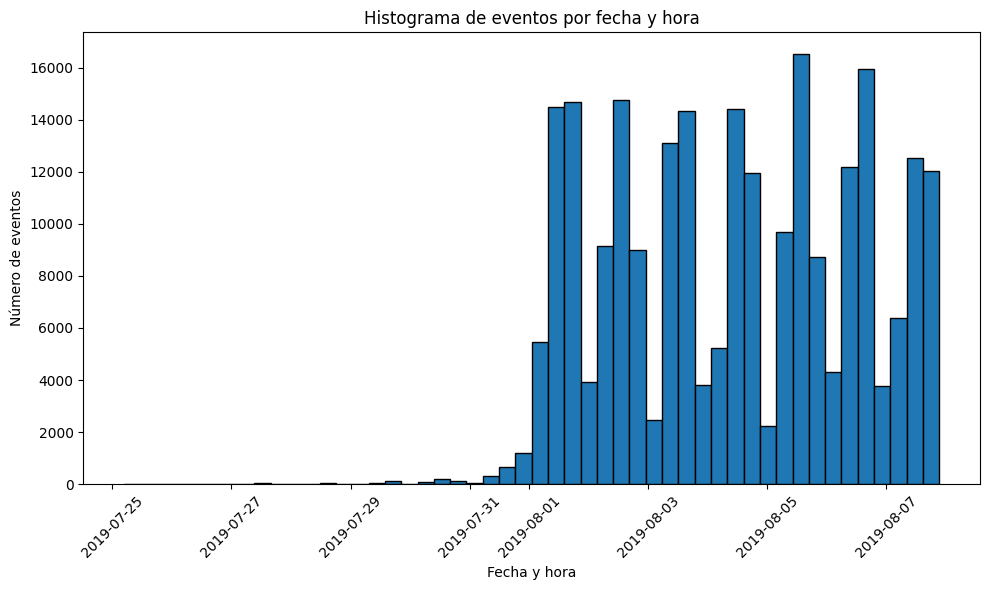

In [15]:
# Trazar histograma de eventos por fecha y hora
plt.figure(figsize=(10, 6))
plt.hist(event['fecha_hora'], bins=50, edgecolor='black')
plt.title("Histograma de eventos por fecha y hora")
plt.xlabel("Fecha y hora")
plt.ylabel("Número de eventos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo?**

In [16]:
eventos_por_fecha = event.groupby('fecha').size()
print(eventos_por_fecha)

fecha
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
dtype: int64


Derivado de este análisis puedo suponer que los datos no pueden estar del todo completos, debido a que en los priemeros días tengo pocos datos y en los últimos tengo la mayoría. Aunque esto es una supocición, se deberá analizar con mayor profundidad.

**Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?**

# ¡¡AYUDA!!

In [17]:
# Agrupar por fecha y por grupo experimental
eventos_por_fecha = event.groupby([event['fecha_hora'].dt.date, 'Experiment_ID']).size().unstack(fill_value=0)

# Ver los primeros registros de eventos por fecha
print(eventos_por_fecha.head())

Experiment_ID  246  247  248
fecha_hora                  
2019-07-25       4    1    4
2019-07-26      14    8    9
2019-07-27      24   23    8
2019-07-28      33   36   36
2019-07-29      55   58   71


In [18]:
# Verificar la cantidad de grupos experimentales
num_grupos = len(event['Experiment_ID'].unique())

# Encontrar los días en los que todos los grupos están presentes
dias_completos = eventos_por_fecha[eventos_por_fecha.sum(axis=1) == num_grupos]

# Verificar si hay días con todos los grupos
if not dias_completos.empty:
    # Si hay días completos, obtener el primer día completo
    primer_dia_completo = dias_completos.index[0]
    print(f"Los datos comienzan a estar completos a partir del: {primer_dia_completo}")
else:
    print("No se encontraron días en los que todos los grupos estén representados.")

No se encontraron días en los que todos los grupos estén representados.


**¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?**

In [19]:
# Filtrar los datos después del primer día completo
eventos_completos = event[event['fecha'] >= primer_dia_completo]

# Contar el número de eventos y usuarios antes y después de excluir los datos más antiguos
eventos_perdidos = num_eventos - eventos_completos.shape[0]
usuarios_perdidos = num_usuarios - eventos_completos['Device_ID'].nunique()

print(f"Eventos perdidos: {eventos_perdidos}")
print(f"Usuarios perdidos: {usuarios_perdidos}")

NameError: name 'primer_dia_completo' is not defined

## Estudiar el embudo de eventos

**Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.**

In [20]:
# Contar la frecuencia de cada evento
frecuencia_eventos = event['Event_Name'].value_counts()

# Mostrar la frecuencia de los eventos, ordenados de mayor a menor
print(frecuencia_eventos)

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: Event_Name, dtype: Int64


**Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.**

In [21]:
# Contar la cantidad de usuarios únicos por evento
usuarios_por_evento = event.groupby('Event_Name')['Device_ID'].nunique()

# Ordenar los eventos por la cantidad de usuarios que realizaron cada uno
usuarios_por_evento_ordenado = usuarios_por_evento.sort_values(ascending=False)

print(usuarios_por_evento_ordenado)

Event_Name
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: Device_ID, dtype: int64


In [22]:
# Calcular la proporción de usuarios que realizaron cada evento al menos una vez
proporcion_usuarios = usuarios_por_evento / num_usuarios

# Mostrar la proporción de usuarios por evento
print(proporcion_usuarios)

Event_Name
CartScreenAppear           0.496491
MainScreenAppear           0.985168
OffersScreenAppear         0.610912
PaymentScreenSuccessful    0.469739
Tutorial                   0.112171
Name: Device_ID, dtype: float64


**¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.**

In [23]:
# Ordenar los eventos por fecha para cada usuario
eventos_ordenados_por_usuario = event.sort_values(by=['Device_ID', 'fecha_hora'])

# Mostrar los primeros eventos de algunos usuarios para observar el orden
primeros_eventos_usuario = eventos_ordenados_por_usuario.groupby('Device_ID').head(3)
print(primeros_eventos_usuario[['Device_ID', 'Event_Name', 'fecha_hora']].head(30))

                Device_ID               Event_Name          fecha_hora
197263   6888746892508752         MainScreenAppear 2019-08-06 14:06:34
209196   6909561520679493         MainScreenAppear 2019-08-06 18:52:54
209199   6909561520679493  PaymentScreenSuccessful 2019-08-06 18:52:58
209200   6909561520679493         CartScreenAppear 2019-08-06 18:52:58
127670   6922444491712477         MainScreenAppear 2019-08-04 14:19:33
127672   6922444491712477  PaymentScreenSuccessful 2019-08-04 14:19:40
127673   6922444491712477         CartScreenAppear 2019-08-04 14:19:40
147627   7435777799948366         MainScreenAppear 2019-08-05 08:06:34
147648   7435777799948366         MainScreenAppear 2019-08-05 08:07:32
147799   7435777799948366         MainScreenAppear 2019-08-05 08:13:29
4580     7702139951469979         MainScreenAppear 2019-08-01 04:29:54
4581     7702139951469979       OffersScreenAppear 2019-08-01 04:29:56
4592     7702139951469979       OffersScreenAppear 2019-08-01 04:30:38
142896

**Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).**

In [24]:
# Definir la secuencia de eventos (A → B → C)
evento_a = 'MainScreenAppear'
evento_b = 'OffersScreenAppear'
evento_c = 'CartScreenAppear'

# Filtrar los usuarios que realizaron cada evento
usuarios_a = event[event['Event_Name'] == evento_a]['Device_ID'].unique()
usuarios_b = event[event['Event_Name'] == evento_b]['Device_ID'].unique()
usuarios_c = event[event['Event_Name'] == evento_c]['Device_ID'].unique()

# Calcular la proporción de usuarios que pasan de A → B → C
proporcion_ab = len(set(usuarios_b) & set(usuarios_a)) / len(usuarios_a)
proporcion_bc = len(set(usuarios_c) & set(usuarios_b)) / len(usuarios_b)

print(f"Proporción A → B: {proporcion_ab}")
print(f"Proporción B → C: {proporcion_bc}")

Proporción A → B: 0.6055921494824573
Proporción B → C: 0.7996965098634294


**¿En qué etapa pierdes más usuarios y usuarias?**

In [25]:
# Calcular las pérdidas de usuarios entre las etapas
perdidos_a_b = len(set(usuarios_a) - set(usuarios_b))
perdidos_b_c = len(set(usuarios_b) - set(usuarios_c))

# Imprimir la etapa en la que se pierden más usuarios
if perdidos_a_b > perdidos_b_c:
    print(f"Se pierden más usuarios entre A y B: {perdidos_a_b}")
else:
    print(f"Se pierden más usuarios entre B y C: {perdidos_b_c}")

Se pierden más usuarios entre A y B: 2934


**¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?**

In [26]:
# Definir los eventos clave
eventos_clave = ['MainScreenAppear', 'Tutorial','OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Filtrar los datos para incluir solo los eventos clave
eventos_filtrados = event[event['Event_Name'].isin(eventos_clave)]

# Ordenar los eventos por usuario y fecha
eventos_ordenados = eventos_filtrados.sort_values(by=['Device_ID', 'fecha_hora'])

# Para cada usuario, verificar si han completado todos los eventos en secuencia
usuarios_completos = []

for device_id, group in eventos_ordenados.groupby('Device_ID'):
    eventos_usuario = group['Event_Name'].tolist()
    
    # Verificar si los eventos están en el orden correcto
    if all(evento in eventos_usuario for evento in eventos_clave):
        # Asegurarse de que los eventos ocurren en el orden correcto
        if eventos_usuario.index(eventos_clave[0]) < eventos_usuario.index(eventos_clave[1]) < eventos_usuario.index(eventos_clave[2]) < eventos_usuario.index(eventos_clave[3]):
            usuarios_completos.append(device_id)

# Calcular el porcentaje de usuarios que completaron todo el viaje
usuarios_totales = event['Device_ID'].nunique()
porcentaje_completado = len(usuarios_completos) / usuarios_totales * 100

# Mostrar el porcentaje de usuarios que completaron el viaje
print(f"Porcentaje de usuarios que completaron el viaje: {porcentaje_completado:.2f}%")

Porcentaje de usuarios que completaron el viaje: 0.04%


Si consideramos el orden de eventos como el siguiente: MainScreenAppear -> Tutorial -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful, solo el 0.04% de los usuarios hicieron el viaje completo.

Como sabemos que no todos ven el tutorial, a continuación se muestra el mismo análisis pero sin considerar la etapa de "Tutorial".

In [27]:
# Definir los eventos clave
eventos_clave = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Filtrar los datos para incluir solo los eventos clave
eventos_filtrados = event[event['Event_Name'].isin(eventos_clave)]

# Ordenar los eventos por usuario y fecha
eventos_ordenados = eventos_filtrados.sort_values(by=['Device_ID', 'fecha_hora'])

# Para cada usuario, verificar si han completado todos los eventos en secuencia
usuarios_completos = []

for device_id, group in eventos_ordenados.groupby('Device_ID'):
    eventos_usuario = group['Event_Name'].tolist()
    
    # Verificar si los eventos están en el orden correcto
    if all(evento in eventos_usuario for evento in eventos_clave):
        # Asegurarse de que los eventos ocurren en el orden correcto
        if eventos_usuario.index(eventos_clave[0]) < eventos_usuario.index(eventos_clave[1]) < eventos_usuario.index(eventos_clave[2]) < eventos_usuario.index(eventos_clave[3]):
            usuarios_completos.append(device_id)

# Calcular el porcentaje de usuarios que completaron todo el viaje
usuarios_totales = event['Device_ID'].nunique()
porcentaje_completado = len(usuarios_completos) / usuarios_totales * 100

# Mostrar el porcentaje de usuarios que completaron el viaje
print(f"Porcentaje de usuarios que completaron el viaje: {porcentaje_completado:.2f}%")

Porcentaje de usuarios que completaron el viaje: 11.07%


Si consideramos el orden de eventos como el siguiente: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful, solo el 11.07% de los usuarios hicieron el viaje completo.

## Estudiar los resultados del experimento

**¿Cuántos usuarios y usuarias hay en cada grupo?**

In [28]:
# Contar cuántos usuarios hay en cada grupo experimental
usuarios_por_grupo = event['Experiment_ID'].value_counts()
print(usuarios_por_grupo)

248    85747
246    80304
247    78075
Name: Experiment_ID, dtype: int64


In [31]:
user_counts = event.groupby('Experiment_ID')['Device_ID'].nunique().reset_index()
user_counts.columns = ['Experiment_ID', 'unique_users']
print(f'Usuarios y usuarias hay en cada grupo, \n{user_counts}')

Usuarios y usuarias hay en cada grupo, 
   Experiment_ID  unique_users
0            246          2489
1            247          2520
2            248          2542


**Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.**

In [32]:
from scipy import stats

# Filtrar los datos para los dos grupos de control
grupo_246 = event[event['Experiment_ID'] == 246]
grupo_247 = event[event['Experiment_ID'] == 247]

# Realizar la prueba t para comparar las medias
t_stat, p_val = stats.ttest_ind(grupo_246['Device_ID'], grupo_247['Device_ID'])

# Mostrar el valor p
print(f"Valor p de la prueba t: {p_val}")

Valor p de la prueba t: 4.80453872580503e-25


Como el valor p es menor que el nivel de significancia (0.05), entonces hay una diferencia estadísticamente significativa entre los grupos 246 y 247.

**Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?**

In [33]:
# Verificar si hay valores nulos en la columna 'Event_Name'
print(event['Event_Name'].isnull().sum())

0


In [34]:
# Contar la frecuencia de cada evento
eventos_frecuencia = event['Event_Name'].value_counts()

# Verificar la frecuencia de los eventos
print(eventos_frecuencia)

# Seleccionar el evento más popular sin idxmax()
evento_popular = eventos_frecuencia.index[0]
print(f"Evento más popular: {evento_popular}")

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: Event_Name, dtype: Int64
Evento más popular: MainScreenAppear


**Luego, calculamos la cantidad de usuarios que realizaron este evento en cada grupo:**

In [35]:
# Filtrar los datos para el evento más popular
evento_popular_usuarios = event[event['Event_Name'] == evento_popular]

# Contar usuarios por grupo para el evento popular
usuarios_evento_popular = evento_popular_usuarios.groupby('Experiment_ID')['Device_ID'].nunique()

# Calcular la proporción
proporciones_evento = usuarios_evento_popular / event.groupby('Experiment_ID')['Device_ID'].nunique()
print(proporciones_evento)

Experiment_ID
246    0.986742
247    0.984921
248    0.983871
Name: Device_ID, dtype: float64


**Comapramos si la diferencia entre los grupos es significativa, con una prueba de proporciones utilizando la función stats.proportions_ztest:**

In [36]:
# Proporciones de usuarios que realizaron el evento
grupo_246_popular = len(evento_popular_usuarios[evento_popular_usuarios['Experiment_ID'] == 246]['Device_ID'].unique())
grupo_247_popular = len(evento_popular_usuarios[evento_popular_usuarios['Experiment_ID'] == 247]['Device_ID'].unique())

# Realizar una prueba de proporciones
count = [grupo_246_popular, grupo_247_popular]
nobs = [event[event['Experiment_ID'] == 246]['Device_ID'].nunique(), event[event['Experiment_ID'] == 247]['Device_ID'].nunique()]
z_stat, p_val = sm.stats.proportions_ztest(count, nobs)

print(f"Valor p de la prueba de proporciones: {p_val}")

Valor p de la prueba de proporciones: 0.5856639791209877


**Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?**

In [37]:
def prueba_evento_por_grupo(evento):
    # Filtrar los datos para el evento
    evento_usuarios = event[event['Event_Name'] == evento]
    
    # Contar usuarios por grupo
    usuarios_evento = evento_usuarios.groupby('Experiment_ID')['Device_ID'].nunique()
    
    # Calcular proporciones
    proporciones = usuarios_evento / event.groupby('Experiment_ID')['Device_ID'].nunique()
    
    # Comparar los grupos (por ejemplo, 246 vs 247) usando prueba de proporciones
    grupo_246_evento = len(evento_usuarios[evento_usuarios['Experiment_ID'] == 246]['Device_ID'].unique())
    grupo_247_evento = len(evento_usuarios[evento_usuarios['Experiment_ID'] == 247]['Device_ID'].unique())
    
    # Realizar una prueba de proporciones
    count = [grupo_246_evento, grupo_247_evento]
    nobs = [event[event['Experiment_ID'] == 246]['Device_ID'].nunique(), event[event['Experiment_ID'] == 247]['Device_ID'].nunique()]
    z_stat, p_val = sm.stats.proportions_ztest(count, nobs)
    
    return proporciones, p_val

# Probar para todos los eventos
eventos = event['Event_Name'].unique()
for evento in eventos:
    proporciones, p_val = prueba_evento_por_grupo(evento)
    print(f"Proporción para el evento {evento}:")
    print(proporciones)
    print(f"Valor p de la prueba para el evento {evento}: {p_val}")
    print("-----")

Proporción para el evento MainScreenAppear:
Experiment_ID
246    0.986742
247    0.984921
248    0.983871
Name: Device_ID, dtype: float64
Valor p de la prueba para el evento MainScreenAppear: 0.5856639791209877
-----
Proporción para el evento PaymentScreenSuccessful:
Experiment_ID
246    0.482925
247    0.460317
248    0.466168
Name: Device_ID, dtype: float64
Valor p de la prueba para el evento PaymentScreenSuccessful: 0.10902546202332887
-----
Proporción para el evento CartScreenAppear:
Experiment_ID
246    0.510245
247    0.492063
248    0.487411
Name: Device_ID, dtype: float64
Valor p de la prueba para el evento CartScreenAppear: 0.19817540651836918
-----
Proporción para el evento OffersScreenAppear:
Experiment_ID
246    0.620731
247    0.607143
248    0.605035
Name: Device_ID, dtype: float64
Valor p de la prueba para el evento OffersScreenAppear: 0.3233225048227193
-----
Proporción para el evento Tutorial:
Experiment_ID
246    0.112093
247    0.113492
248    0.110936
Name: Device_I

Los análisis muestran que no hay diferencias importantes entre los grupos en cuanto a los eventos clave que realizaron los usuarios, como ver la pantalla principal, ver ofertas, agregar productos al carrito, realizar un pago o completar el tutorial. Las diferencias son pequeñas y no son estadísticamente relevantes, lo que sugiere que los grupos están equilibrados y no hay sesgo en cómo se distribuyeron los usuarios. Esto indica que los resultados del experimento son confiables y que los grupos fueron divididos de manera adecuada.

**¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado.**

El nivel de significación que use fue de 0.05